In [1]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#


# Wire Antenna Basics:  Design Optimization

## Optimizing for minimum peak VSWR within a band of interest

This page demonstrates the most basic sort of antenna optimization: adjusting an antenna's dimensions to produce the lowest peak VSWR within some band of frequencies. For the moment we won't be taking into account any matching schemes, just direct feedline connection to the antenna. Some examples using series section matching, for example, will be presented in subsequent files.

We'll be using the excellent Pymoo optimization library [https://pymoo.org](https://pymoo.org).

This library contains a host of optimization algorithms, but at the moment we'll only be using a simple single-objective genetic algorithm. Elsewhere on this site we'll have examples of more advanced tasks, e.g. multi-objective optimization to explore trade-offs between forward gain, F/B, and bandwidth in Yagi design.



### Example 1: A Simple Dipole

Find the optimum length for a dipole antenna to minimize the peak VSWR within a frequency range.

Pymoo requires the creation of a Problem class that encapsulates the details of the problem to be solved. You should be able to reuse this code with only minor modification for your own similar designs.



In [3]:
import numpy as np
from pymoo.core.problem import Problem
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, translate, make_cage_element


#
# A base class for simple single-objective problems (e.g. minimize dipole vswr within a band)
#
class DipoleSingleOptProblem(Problem):
    
    # Initialization:
    #   n_var       number of variables (parameters)...only one in this case (antenna length)
    #   segs_per_m  NEC segments per meter of wire length...used when generating NEC cards for simulation
    #   radius      wire radius (in meters, as are all other dimensions)
    #   f_min,f_max,f_num   freq range of interest (lower/upper limits, number of points)
    #
    def __init__(self, n_var, segs_per_m, radius, f_min, f_max, z, f_num=9, **kwargs):
        super().__init__(n_var=n_var,
                         n_obj=1,
                         n_ieq_constr=0,
                         **kwargs)

        # Save various data in your Problem object
        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC secgents per meter 
        self.radius = radius            # Wire radius (m)
        
        # NEC5 design deck template
        #   GX: mirror across xz plane
        #   EX: feedpoint specified as tag=1, segment=1, near end (1)
        #   GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 
    #
    # Take the parameters for a single antenna design and generate a NEC card deck for simulation
    # Since we have only one parameter, 'x' is an array with only one element (half-length of dipole)
    # *** You'll write your own version of _make_design() to customize this for your specific problem
    #
    def _make_nec5_design(self, x):
        design = self._make_design(x)                                   # The design as array of endpoints
        nec_str = gen_nec5_str(design, self.segs_per_m, self.radius)    # Convert to a string of NEC cards
        return self.necpre + nec_str + self.necpost                     # Return as complete NEC deck


    # 
    # _evaluate() is called by pymoo for every new generation of designs ('offspring') 
    #   
    # Evaluate the designs in X, an array of shape (population_size, number_of_variables)
    # Return values for the objectives(s) to be minimized, and constraints to be met, in dictionary 'out'
    #
    def _evaluate(self, X, out, *args, **kwargs):

        # Customize _make_nec5_design() for your specific problem
        designs = [self._make_nec5_design(x) for x in X]             # Make a list of NEC decks, one per row of X

        res = nec5_sim_stdio3(designs, timelimit=10000.0)           # Run the simulations

        # Our 'XQ' card produces feedpoint impedances that look like:
        #  res[design#][0][0] = 
                    # [[28.0, (18.156-28.716j)],
                    # [28.05, (18.262-26.878j)],
                    # [28.1, (18.338-25.051j)],
                    # [28.15, (18.383-23.23j)],
                    # [28.2, (18.396-21.412j)],
                    # [28.25, (18.377-19.592j)],
                    # [28.3, (18.325-17.767j)],
                    # [28.35, (18.243-15.933j)],
                    # [28.4, (18.129-14.086j)]]

        # See the file 'Basics/020_Understanding_Response_Format.ipynb' for details on the data returned by th simulation


        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Each row in 'vswr_curves' is the vswr curve across the band for one of the designs
        abs_refl_coef = np.abs((zs - self.z0) / (zs + self.z0))         # Reflection coefs
        vswr_curves = (1 + abs_refl_coef) / (1 - abs_refl_coef)         # Vswr
        max_vswr = np.max(vswr_curves, axis=1)[:,None]                  # Max vswr within band for each design (as column vector)

        # Return the objective value we're minimizing (simply the max vswr in this case)
        out["F"] = max_vswr

        # You can also attach other data to the population of designs
        # This isn't used in the optimization, but you can examine it later
        # We'll save the vswr curves for each
        out["VSWR"] = vswr_curves





The above code will be reused for various similar problems.
The following code is all we need to write to define our specific problem:

In [4]:
AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element
#
# Create a class to represent your problem,
#  and write a function _make_design() to construct your antenna from the given parameter(s)
#
class SimpleDipoleProblem(DipoleSingleOptProblem):
    
    # This is where you 'draw' your antenna for the specified design parameters
    # 'x' is a vector with the params; since our only param is the dipole half-length
    #  it contains only that value (in meters)

    # As explained in '010_Wire_Antennas.ipynb', we describe the antenna as a list of one or more numpy arrays
    # The viewer also uses this format to display your creation
    def _make_design(self, x):
        return make_linear_element((0,0,self.z),(0,x[0],self.z))    # A single segment between two points

# Create a Problem object that specifies your freq range, z (elevation), etc.
# 'xl' and 'xh' give the lower and upper limits of the design parameters (only one in this case)
sdproblem = SimpleDipoleProblem(n_var=1, f_min=3.5, f_max=3.6, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([18.0]),
                                xu=np.array([22.0]))


In [5]:
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA

# For the sake of simplicity we're just going to run the optimization for 50 generations
# Pymoo has a variety of more-sophisticated termination criteria based on changes in the design variables
#  and objective values that would shorten the run time considerably....
termination = get_termination("n_gen", 50)

# Pymoo provides many optimization algorithms but we're just going to use the simplest genetic algorithm 'GA'
#  with an initial population of 200 designs and 100 offspring in each subsequent generation
algorithm = GA(pop_size=200, n_offsprings=100)

# Finally, run the optimization...
res = minimize(sdproblem,
               algorithm,
               termination,
               save_history=False,
               verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  9.6238988202 |  1.7728442288
     2 |      300 |  3.5758417506 |  1.7728442288
     3 |      400 |  2.4353680048 |  1.7728442288
     4 |      500 |  2.0712727094 |  1.7638488241
     5 |      600 |  1.9468493905 |  1.7638488241
     6 |      700 |  1.8878257691 |  1.7638488241
     7 |      800 |  1.8424305301 |  1.7638488241
     8 |      900 |  1.8193634800 |  1.7638488241
     9 |     1000 |  1.8043822989 |  1.7638488241
    10 |     1100 |  1.7924202313 |  1.7636125734
    11 |     1200 |  1.7852668117 |  1.7632107567
    12 |     1300 |  1.7789946631 |  1.7630701679
    13 |     1400 |  1.7744615707 |  1.7630701679
    14 |     1500 |  1.7715815446 |  1.7630701679
    15 |     1600 |  1.7694920520 |  1.7630701679
    16 |     1700 |  1.7675832474 |  1.7630701679
    17 |     1800 |  1.7664557937 |  1.7630701679
    18 |     1900 |  1.7656933473 |  1.7630701679
    19 |     2000 |  1.7651189492 |  1.7630701679


Optimum length 20.9m, max VSWR 1.76


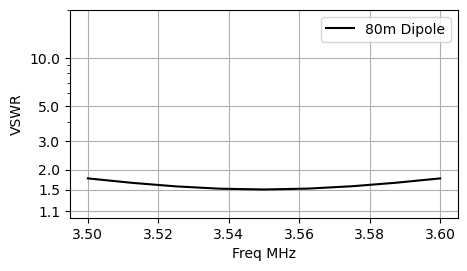

In [5]:

# Upon completion, the following data are returned:
#   res.X       parameters of the optimum design (just the length of half-dipole in this case)
#   res.F       the objective value we minimized (VSWR in our frequency band)

# We can retrieve the vswr curves we attached to our population of designs like this:
#   res.pop.get('VSWR')

print(f'Optimum length {res.X[0]:.1f}m, max VSWR {res.F[0]:.2f}')
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(sdproblem.freqs, vswr_curve)], tags=['80m Dipole'])



Visualize your resulting antenna:

![Graph](img/Dipole_opt.png)

In [6]:
# Convert parameters into format used by 3D visualizer
design = sdproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45),width=400, height=400)



### Example 2: Inverted Vee

Now we'll repeat the same problem but with an inverted vee, which has two parameters (length, droop angle) instead of one:

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  1.165639E+01 |  2.4321657280
     2 |      300 |  4.7269959541 |  2.3539279983
     3 |      400 |  3.4094624954 |  2.3539279983
     4 |      500 |  2.9021687239 |  2.3539279983
     5 |      600 |  2.6998338255 |  2.3539279983
     6 |      700 |  2.5926446878 |  2.3450677408
     7 |      800 |  2.5101201437 |  2.3450677408
     8 |      900 |  2.4591768821 |  2.3450677408
     9 |     1000 |  2.4283100452 |  2.3423243166
    10 |     1100 |  2.4117286290 |  2.3423243166
    11 |     1200 |  2.3995624196 |  2.3423243166
    12 |     1300 |  2.3866429369 |  2.3367730817
    13 |     1400 |  2.3801162804 |  2.3351670692
    14 |     1500 |  2.3750473185 |  2.3351670692
    15 |     1600 |  2.3676751034 |  2.3351670692
    16 |     1700 |  2.3639926326 |  2.3351670692
    17 |     1800 |  2.3599948130 |  2.3351670692
    18 |     1900 |  2.3566196259 |  2.3351670692
    19 |     2000 |  2.3536168734 |  2.3351670692


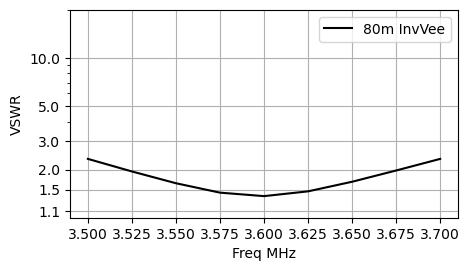

In [9]:

# The only significant change required is to write a new version of _make_design()
#  that draws the inverted vee with the required length and angle.
# 'x' is now a vector of two values:
#   x[0]    half-dipole length (meters)
#   x[1]    droop angle (degrees, a negative value)
class InvVeeProblem(DipoleSingleOptProblem):
    
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,x[0],0))       # Draw the element along the y axis
        half_el = rot_x(half_el, np.deg2rad(x[1]))              # Rotate around x axis
        half_el = translate(half_el, (0,0,self.z))              # Move up to desired z coordinate
        return half_el

# xl,xu specify valid ranges of parameter values:  length (18, 22) meters, angle (-45, 0) degrees
ivproblem = InvVeeProblem(n_var=2, f_min=3.5, f_max=3.7, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([18.0, -45.0]),
                                xu=np.array([22.0, 0.0]))
res = minimize(ivproblem, algorithm, termination, save_history=False, verbose=True)

print(f'Optimum length {res.X[0]:.1f}m, angle {res.X[1]:.1f}deg, max VSWR {res.F[0]:.2f}')
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(ivproblem.freqs, vswr_curve)], tags=['80m InvVee'])

design = ivproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45),width=400, height=400)


![Graph](img/InvVee_opt.png)


### Example 3: Cage Dipole

![Graph](img/Cage_opt.png)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  3.9956270253 |  1.5986794813
     2 |      300 |  2.6708522277 |  1.5866224286
     3 |      400 |  2.1181677897 |  1.5866224286
     4 |      500 |  1.8860004519 |  1.5866224286
     5 |      600 |  1.7626420960 |  1.5866224286
     6 |      700 |  1.6891573589 |  1.5866224286
     7 |      800 |  1.6551575316 |  1.5866224286
     8 |      900 |  1.6361132521 |  1.5866224286
     9 |     1000 |  1.6213277567 |  1.5866224286
    10 |     1100 |  1.6116936562 |  1.5862457454
    11 |     1200 |  1.6046333879 |  1.5862457454
    12 |     1300 |  1.5993852502 |  1.5862295915
    13 |     1400 |  1.5961424719 |  1.5862295915
    14 |     1500 |  1.5938125119 |  1.5861414639
    15 |     1600 |  1.5924528626 |  1.5861414639
    16 |     1700 |  1.5910026107 |  1.5860773392
    17 |     1800 |  1.5900923222 |  1.5860773392
    18 |     1900 |  1.5892112067 |  1.5860773392
    19 |     2000 |  1.5882764765 |  1.5860773392


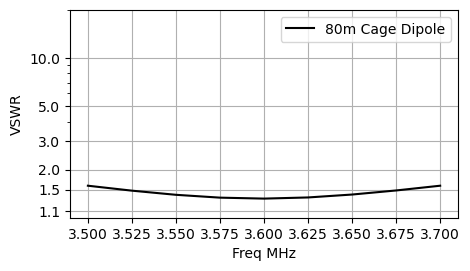

In [6]:
class CageDipoleProblem(DipoleSingleOptProblem):
    
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))                # Start with a 0.5m linear section
        half_el.extend( make_cage_element(0.5, x[0]+0.5, .2, .5, 4) )   # Our parameter x[0] is the length of the 'cage' section
        half_el = translate(half_el, (0,0,self.z))
        return half_el
    
cdproblem = CageDipoleProblem(n_var=1, f_min=3.5, f_max=3.7, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([17.0]),
                                xu=np.array([23.0]))
res = minimize(cdproblem, algorithm, termination, save_history=False, verbose=True)

print(f'Optimum length {res.X[0]:.1f}m, max VSWR {res.F[0]:.2f}')
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(cdproblem.freqs, vswr_curve)], tags=['80m Cage Dipole'])

design = cdproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45),width=400, height=400)


### Example 4: Cage Vee Dipole

![Graph](img/CageVee_opt.png)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  4.0611534304 |  1.6046532100
     2 |      300 |  2.6974083801 |  1.5232410116
     3 |      400 |  2.1003143568 |  1.5232410116
     4 |      500 |  1.8382190595 |  1.5191361150
     5 |      600 |  1.7152954513 |  1.5191361150
     6 |      700 |  1.6580065207 |  1.5173006767
     7 |      800 |  1.6191028388 |  1.5149220035
     8 |      900 |  1.5927928236 |  1.5034770577
     9 |     1000 |  1.5746681969 |  1.4966921254
    10 |     1100 |  1.5577020481 |  1.4866920594
    11 |     1200 |  1.5458172699 |  1.4829224497
    12 |     1300 |  1.5387629854 |  1.4829224497
    13 |     1400 |  1.5331001625 |  1.4829224497
    14 |     1500 |  1.5266812252 |  1.4829224497
    15 |     1600 |  1.5218654247 |  1.4829224497
    16 |     1700 |  1.5177144860 |  1.4829224497
    17 |     1800 |  1.5152620544 |  1.4829224497
    18 |     1900 |  1.5115508408 |  1.4822379789
    19 |     2000 |  1.5089722151 |  1.4822379789


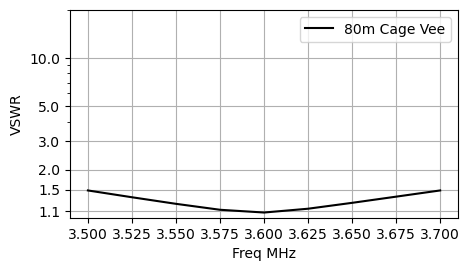

In [7]:
class CageVeeProblem(DipoleSingleOptProblem):
    
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))
        half_el.extend( make_cage_element(0.5, x[0]+0.5, .2, .5, 4) )
        half_el = rot_x(half_el, np.deg2rad(x[1]))
        half_el = translate(half_el, (0,0,self.z))
        return half_el

cvproblem = CageVeeProblem(n_var=2, f_min=3.5, f_max=3.7, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([17.0, -45]),
                                xu=np.array([23.0, 0]))
res = minimize(cvproblem, algorithm, termination, save_history=False, verbose=True)

print(f'Optimum length {res.X[0]:.1f}m, angle {res.X[1]:.1f}deg, max VSWR {res.F[0]:.2f}')
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(cvproblem.freqs, vswr_curve)], tags=['80m Cage Vee'])

design = cvproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45),width=400, height=400)
